# Exploratory data analysis
This tutorial covers the basics of exploratory data analysis, specifically raster plots and PSTHs.

When analyzing data, it is useful to consider that brains must accomplish the exact same process. They receive raw data in the form of various sensory information, and must transform, clean up, and analyze that data. This tutorial attempts to map various parts of data analysis onto parts of the sensory pathway that might accomplish the same thing...


# Data and Task
The dataset was recorded from M1 neurons in a monkey performing a center-out reaching task. The monkey had to reach towards different targets, each at a different angle. On each trial, the target angle and onset was recorded.

In [2]:
import numpy as np
from scipy import io as si
from matplotlib import pyplot as plt
import h5py
%matplotlib inline

There are a few variables of interest. In particular:
* spikes = data
* startBins = beginning of each trial

# Load the data (transduction)

In [3]:
data = si.loadmat('../data/StevensonV4.mat')

# Load in the spiking data
spikes = data['spikes']

In [4]:
# First we'll set our constants to be used later
numCond = 8 # Number of conditions
neuron_ix = 192 # Which neuron are we looking at?
neuron = spikes[neuron_ix]

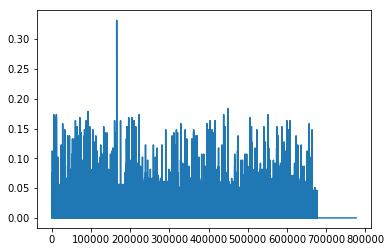

In [5]:
# Calculate the mean across neurons and plot it for a quick viz
mean_spikes = np.mean(spikes, 0)
_ = fig, ax = plt.subplots()
ax.plot(mean_spikes)

# Pruning (thalamus)

In [6]:
# Only process what constitutes valid trials - identify malformed ones
startBins = data['startBins'][0]
targetNumbers = data['targetNumbers'][:, 0]

In [7]:
# We'll only keep the trials that occur before the final time of our data
end_ix = 676790
mask_keep = startBins < end_ix
startBins = startBins[mask_keep]
targetNumbers = targetNumbers[mask_keep]

Had 180, 155 valid ones left

#  Data formatting / preprocessing (V1)
This data is already fairly preprocessed and cleaned. This is because it was used in a prior publication (thanks to Konrad Kording).

In [8]:
# We'll use a dictionary to map each condition type onto its corresponding trials
condition_dict = {}
for ii in range(1, numCond + 1):
    condition_dict[ii] = np.where(targetNumbers == ii)[0]

#  Exploratory analysis - Raster plots
It is important to look at your raw data (after some degree of cleaning). When recording from neurons, the raw data takes the form of **raster plots**, which show the spiking activity of a neuron over time.

In [9]:
# This defines the sampling frequency of the data
tstep = data['time'][0][1] - data['time'][0][0]
# We infer the sfreq from the time step
sfreq = 1. / tstep

# Define how we'll take a window around each event
tmin, tmax = -.5, 10
ixmin = int(tmin * sfreq)
ixmax = int(tmax * sfreq)

In [10]:
# Now loop through conditions
cond_data = {}
for cond in range(1, numCond + 1):
    # For each condition, we'll take a window of time around each onset
    indices = condition_dict[cond]
    this_onsets = startBins[indices]

    epochs = []
    for onset in this_onsets:
        if (onset + ixmax) > spikes.shape[-1]:
            # If the window extends beyond the data, skip it
            continue
        epochs.append(spikes[:, onset + ixmin : onset + ixmax])
    epochs = np.array(epochs)
    cond_data[cond] = epochs
    
# Time (in seconds) around each window
time_epochs = np.linspace(tmin, tmax, num=epochs.shape[-1])

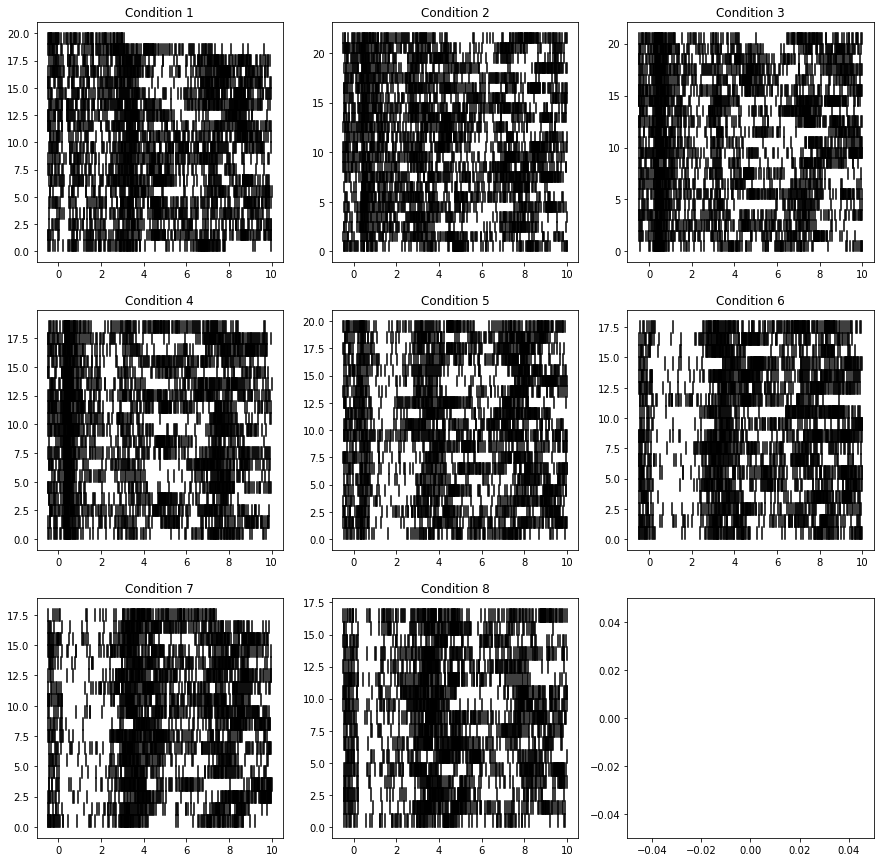

In [11]:
# Now, we can plot the spiking activity (rasters) in response to each condition
n_row = 3
n_col = int(np.ceil(numCond / float(n_row)))
fig, axs = plt.subplots(n_row, n_col, figsize=(5 * n_col, 5 * n_row))
for ax, (cond, i_data) in zip(axs.ravel(), cond_data.items()):
    this_epoch = i_data[:, neuron_ix, :]
    for ii, i_ep in enumerate(this_epoch):
        mask_spikes = i_ep == 1
        ixs_spikes = np.where(mask_spikes)[0]
        times_spikes = time_epochs[ixs_spikes]
        if len(times_spikes) > 0:
            ax.plot([times_spikes, times_spikes], [ii, ii+1], c='k')
    ax.set_title('Condition {}'.format(cond))
    plt.autoscale(tight=True)

# Now we create a PSTH
It is helpful to summarize the spiking activity across repetitions of one condition. For this, we create the peri-stimulus time histogram (PSTH). This shows us the general pattern of spiking activity in response to a stimulus.

In [12]:
# We'll use this to smooth in time, which is important when using spikes
from scipy.ndimage.filters import gaussian_filter1d

In [13]:
# Smooth the spiking activity, then take every "Nth" sample to reduce size
gaussian_sd = 5
binned_dict = {}
for i_cond, i_data in cond_data.items():
    i_data = gaussian_filter1d(i_data.astype(float), gaussian_sd, axis=-1)
    i_data = i_data[..., ::5]
    binned_dict[i_cond] = i_data

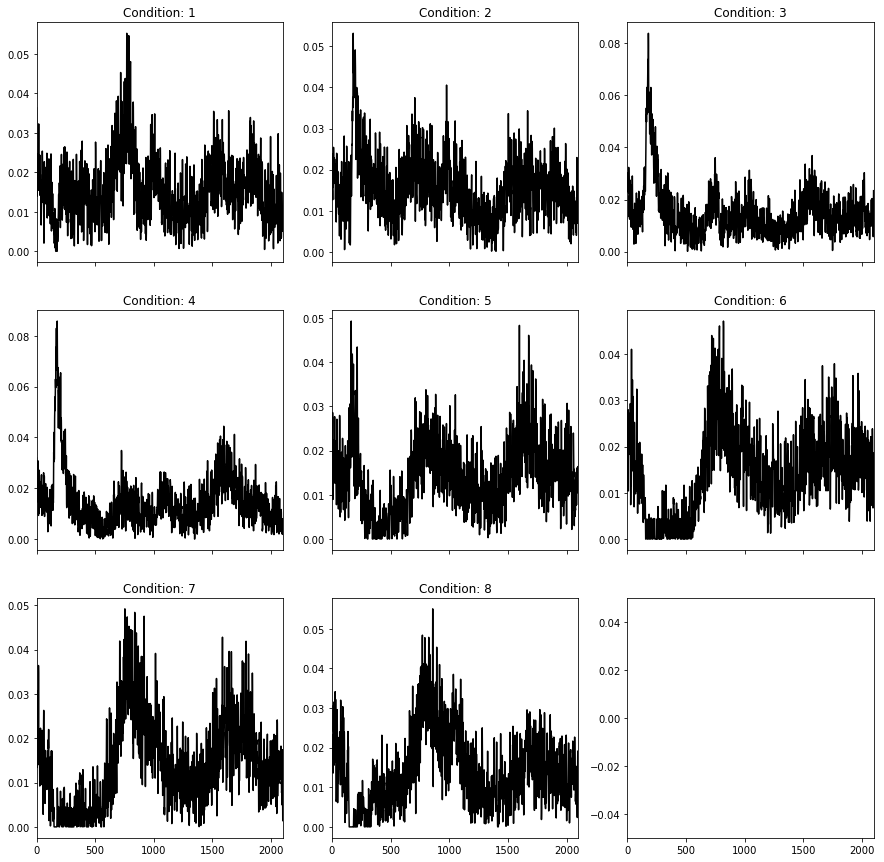

In [14]:
# Compare this plot with the raster images above
n_row = 3
n_col = int(np.ceil(numCond / float(n_row)))
fig, axs = plt.subplots(n_row, n_col, figsize=(5 * n_col, 5 * n_row), sharex=True)
for ax, (i_cond, i_data) in zip(axs.ravel(), binned_dict.items()):
    ax.plot(i_data.mean(0)[192], 'k')
    ax.set_title('Condition: {}'.format(i_cond))
plt.autoscale(tight=True)

The PSTH is a summary of activity, and as such it more useful in understanding what is going on. However, as with any summary statistic, we've also removed some information about the data (we did this when collapsing across trials). Be careful to consider what information you may be removing (and what assumptions you may be violating) when you calculate statistics.